# Milestone 2: Project proposal and initial analyses

We chose the **[CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/)**. This dataset contains 42,306 movie plot summaries extracted from Wikipedia + aligned metadata extracted from Freebase.

Using this dataset, we want to dive into the **drivers of an actor's success**, following several definitions.

In [56]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## 1. Exploration of the dataset

Many variables of the dataset are relevant to predict the success of an actor or an actress. Some are present in the characters dataset:
- Age at the beginning of their careers
- Age at the time of the movie
- Gender
- Ethnicity
- Height

Some are present in the movie dataset, but would need to be aggregated by actor:
- Movie release date (relative to the first film?): maybe some actors released their average movie during the golden age of the film industry?
- Movie language: maybe some languages allow to touch more people?
- Country of the movie: the country with the most occurence?

Some have to be constructed for this analysis:
- Variety of film genres in which the actor has played
- Variety of roles portrayed with an analysis of personas

### Movies metadata

In [57]:
movies = pd.read_table('Data/MovieSummaries/movie.metadata.tsv', header=None)
movies.columns = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date','Movie box office revenue','Movie runtime','Movie languages','Movie countries','Movie genres']
display(movies)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


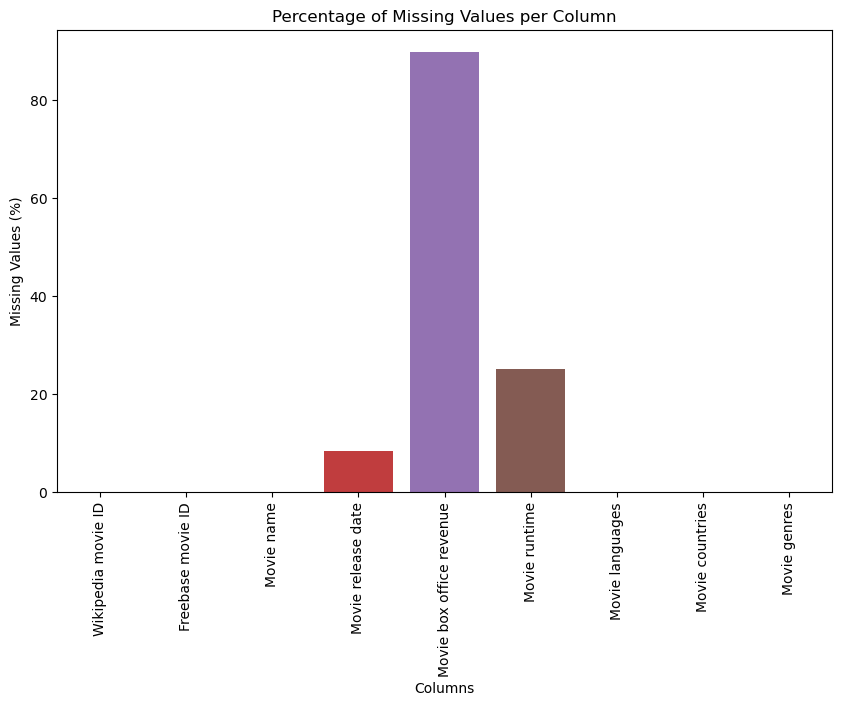

In [58]:
# Count missing values per column
missing_percent = (movies.isna().mean() * 100)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values)
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Missing Values (%)')
plt.title('Percentage of Missing Values per Column')
plt.show()

# How will we deal with the large share of missing values for a key feature?

In [59]:
# Frequency of movie release
movies_release = movies['Movie release date'].dropna().copy()
movies_release = movies_release.reset_index()

movies_release.loc[:,'Release date'] = pd.to_datetime(movies_release['Movie release date'], format='mixed', errors='coerce') # convert release date into date format 

print('The first movie was released on {}.'.format(movies_release['Release date'].min()))
# movies_release['Relative release date'] = (movies_release['Release release date'] - movies_release['Release date'].min()).dt.days # and then into float

The first movie was released on 1888-01-01 00:00:00.


In [60]:
movies_release['Release date'].min() # Error? The function to_datetime itself doesn't accept dates that are too old

Timestamp('1888-01-01 00:00:00')

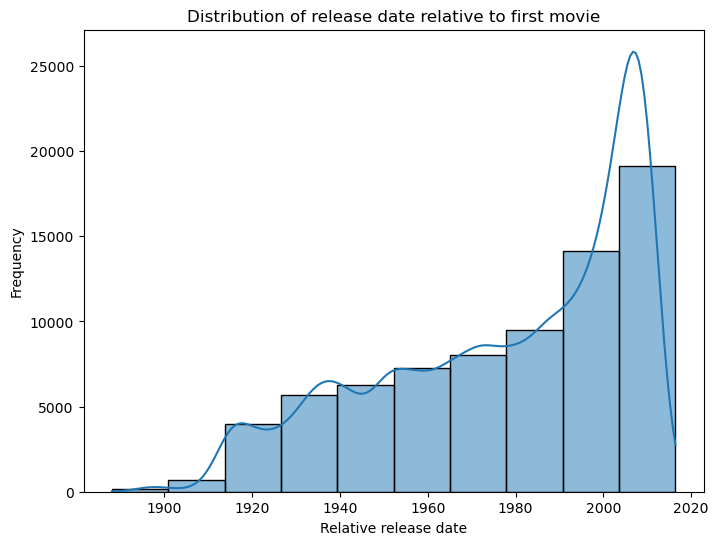

In [61]:
# Create a distribution plot using seaborn
plt.figure(figsize=(8, 6))
sns.histplot(data=movies_release, x='Release date', kde=True, bins=10)  # You can adjust the number of bins as needed
plt.xlabel('Relative release date')
plt.ylabel('Frequency')
plt.title('Distribution of release date relative to first movie')
plt.show()

In [62]:
import ast 

# Remove leading and trailing spaces, then parse the dictionaries
movies['Movie languages'] = movies['Movie languages'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie countries'] = movies['Movie countries'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie genres'] = movies['Movie genres'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})

In [63]:
movies

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'}
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'}
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,{'/m/02h40lc': 'English Language'},"{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{'/m/03bxz7': 'Biographical film', '/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ..."


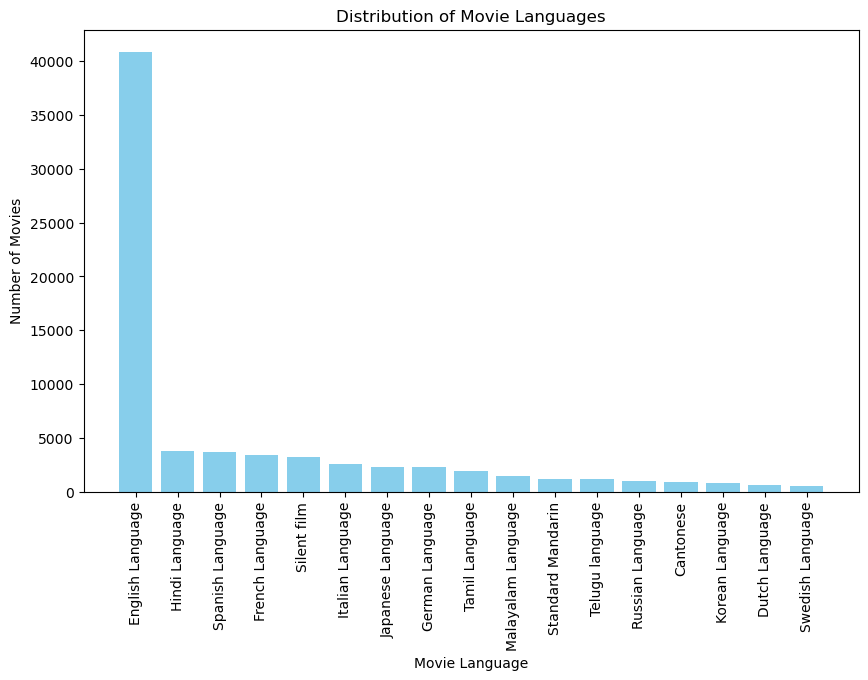

In [64]:
# Flatten the dictionaries and count language occurrences
language_counts = Counter(language for languages_dict in movies["Movie languages"] for language in languages_dict.values())

# Filter the language counts for readability
filtered_language_counts = {language: count for language, count in language_counts.items() if count > 500}
sorted_filtered_language_counts = dict(sorted(filtered_language_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
languages, counts = zip(*sorted_filtered_language_counts.items())
plt.bar(languages, counts, color='skyblue')
plt.xlabel('Movie Language')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Languages')
plt.xticks(rotation=90)  
plt.show()

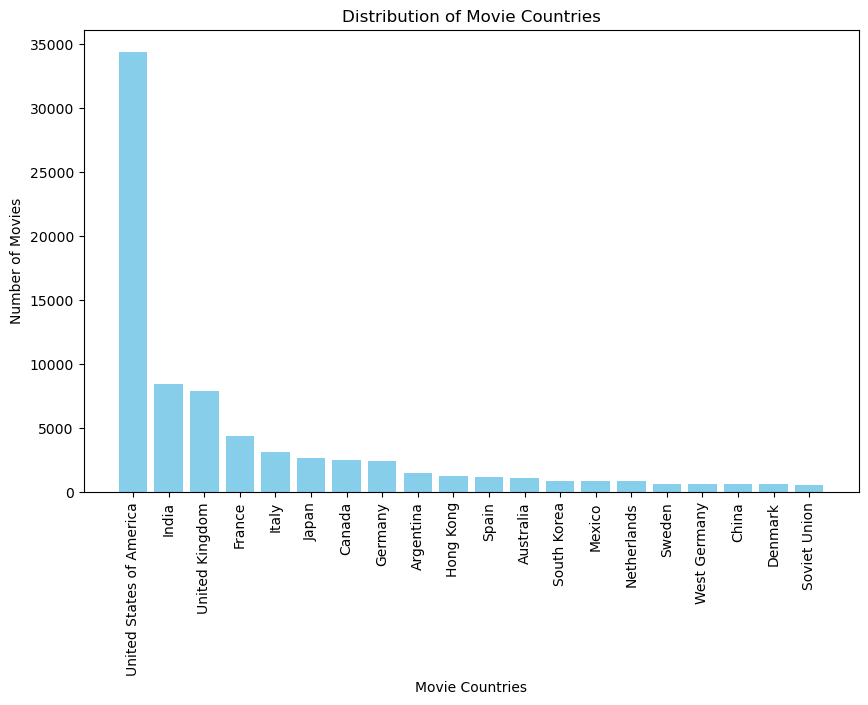

In [65]:
# Flatten the dictionaries and count countries occurrences
countries_counts = Counter(country for countries_dict in movies["Movie countries"] for country in countries_dict.values())

# Filter the language counts for readability
filtered_countries_counts = {country: count for country, count in countries_counts.items() if count > 500}
sorted_filtered_countries_counts = dict(sorted(filtered_countries_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
countries, counts = zip(*sorted_filtered_countries_counts.items())
plt.bar(countries, counts, color='skyblue')
plt.xlabel('Movie Countries')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Countries')
plt.xticks(rotation=90)  
plt.show()

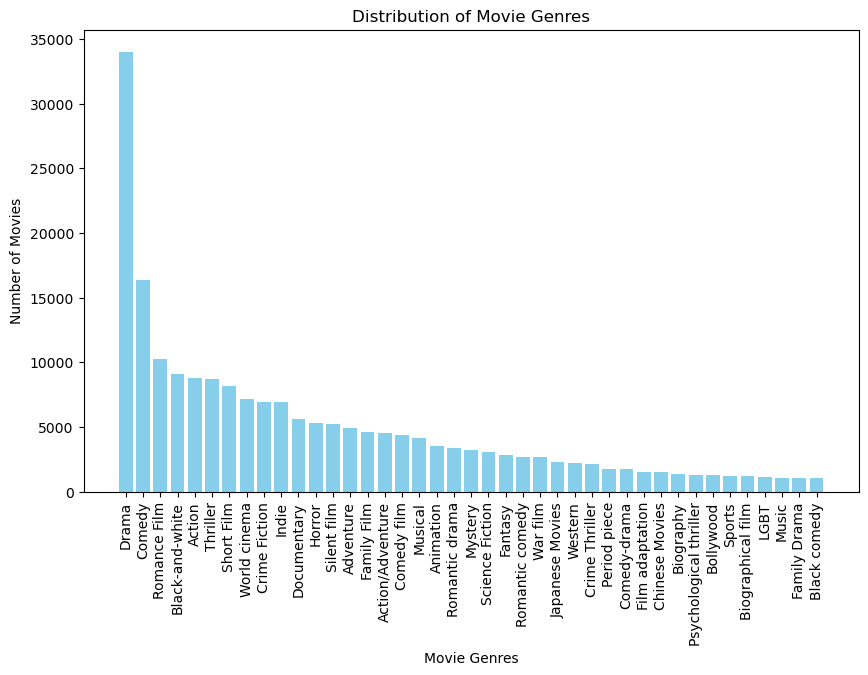

In [66]:
# Flatten the dictionaries and count countries occurrences
genres_counts = Counter(genre for genres_dict in movies["Movie genres"] for genre in genres_dict.values())

# Filter the language counts for readability
filtered_genres_counts = {genre: count for genre, count in genres_counts.items() if count > 1000}
sorted_filtered_genres_counts = dict(sorted(filtered_genres_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
genres, counts = zip(*sorted_filtered_genres_counts.items())
plt.bar(genres, counts, color='skyblue')
plt.xlabel('Movie Genres')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=90)
plt.show()

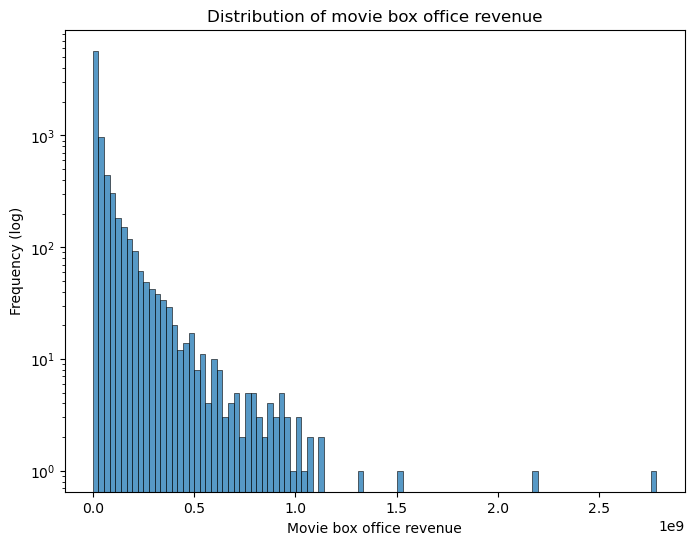

In [67]:
movies_revenues = movies['Movie box office revenue'].dropna().copy()

# Create a distribution plot using seaborn
plt.figure(figsize=(8, 6))
sns.histplot(data=movies_revenues, kde=False, bins=100)
plt.xlabel('Movie box office revenue')
plt.ylabel('Frequency (log)')
plt.title('Distribution of movie box office revenue')
plt.yscale("log")
plt.show()

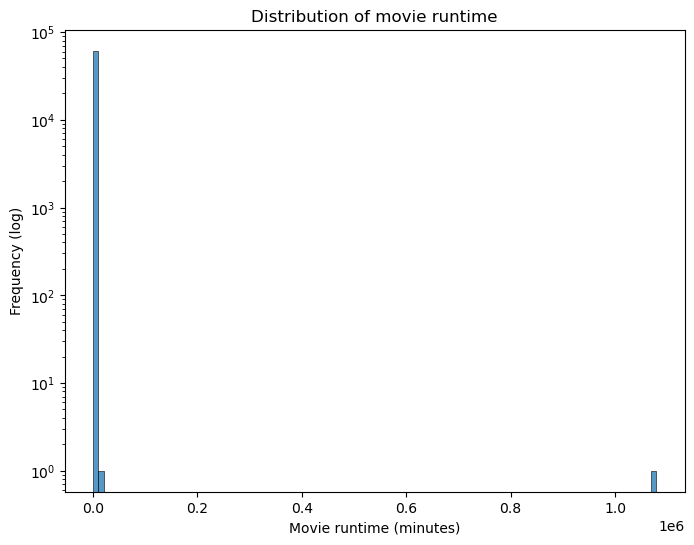

In [68]:
# Create a distribution plot using seaborn
plt.figure(figsize=(8, 6))
sns.histplot(data=movies['Movie runtime'], kde=False, bins=100)
plt.xlabel('Movie runtime (minutes)')
plt.ylabel('Frequency (log)')
plt.title('Distribution of movie runtime')
plt.yscale("log")
plt.show()

In [69]:
movies['Movie runtime'].max() # some movies are very long so the graph isn't clear

1079281.0

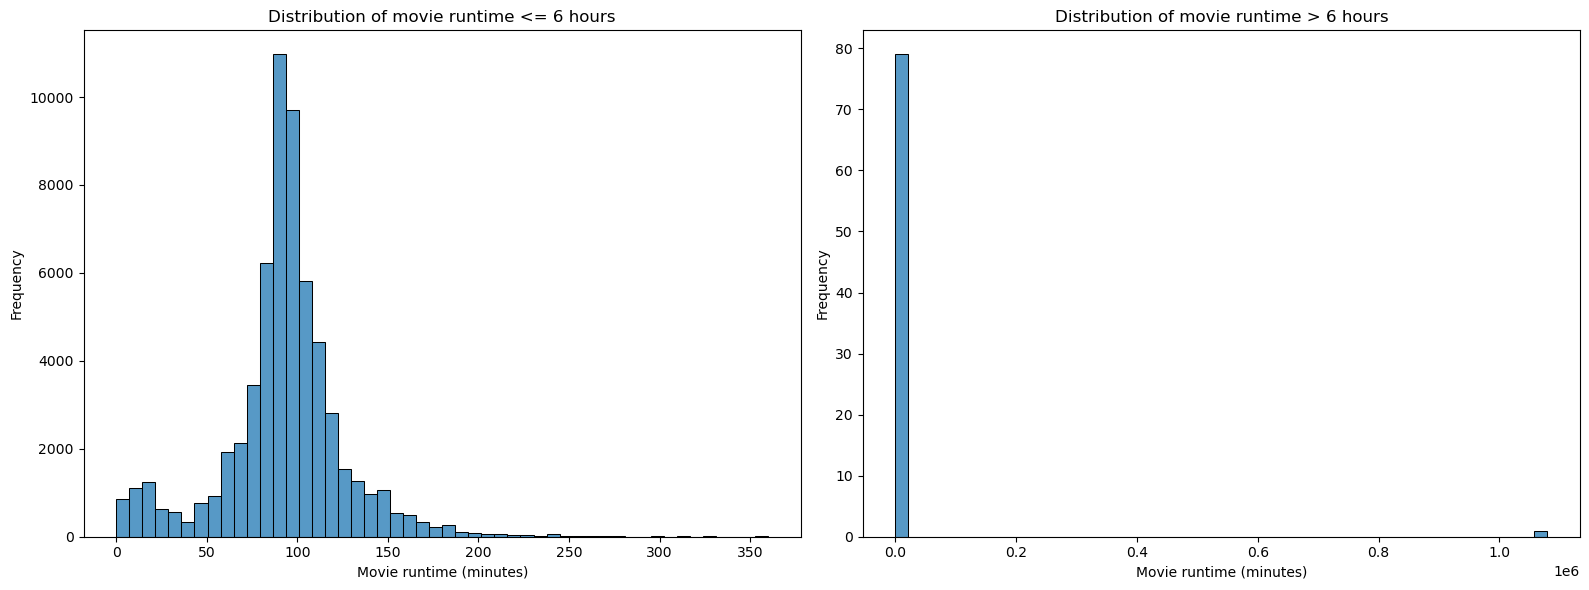

In [70]:
# we could also use a log scale but here we are interested in the absolute values of the extremes

movies_runtime = movies['Movie runtime'][(movies['Movie runtime'] <= 360)].dropna()
movies_runtime_long = movies['Movie runtime'][(movies['Movie runtime'] > 360)].dropna()

# Create subplots with two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first distribution (movie runtimes <= threshold)
sns.histplot(data=movies_runtime, kde=False, bins=50, ax=axes[0])
axes[0].set_xlabel('Movie runtime (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of movie runtime <= 6 hours')

# Plot the second distribution (movie runtimes > threshold)
sns.histplot(data=movies_runtime_long, kde=False, bins=50, ax=axes[1])
axes[1].set_xlabel('Movie runtime (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of movie runtime > 6 hours')

plt.tight_layout()
plt.show()

### Characters metadata

In [71]:
characters = pd.read_table('Data/MovieSummaries/character.metadata.tsv', header=None)
characters.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date','Character name','Actor date of birth','Actor gender','Actor height','Actor ethnicity','Actor name','Actor age at movie release','Freebase character/actor map ID','Freebase character ID','Freebase actor ID']
display(characters)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


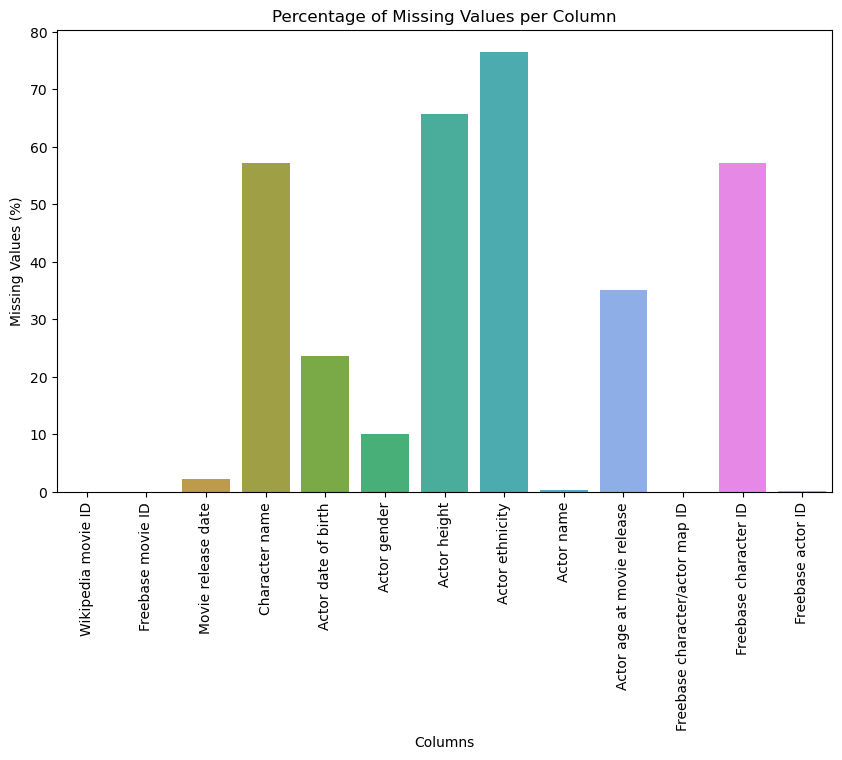

In [72]:
# Count missing values per column
missing_percent = (characters.isna().mean() * 100)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values)
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Missing Values (%)')
plt.title('Percentage of Missing Values per Column')
plt.show()

In [73]:
# Get summary statistics
summary = characters.describe()
summary = summary.loc[['count','mean', 'std', '50%']]
# Get the most frequent values
most_frequent = characters.mode().iloc[0]

# Get the number of missing values
missing_values = characters.isnull().sum()

# Combine the summary statistics into a single DataFrame
description = pd.concat([most_frequent, missing_values, summary.T], axis=1)
description.columns = ['Most Frequent', 'Missing', 'Count', 'Mean', 'Std', '50%']

# Display the description
print(description)

                                Most Frequent  Missing     Count  \
Wikipedia movie ID                 27872371.0        0  450669.0   
Freebase movie ID                  /m/0cc8620        0       NaN   
Movie release date                       2008     9995       NaN   
Character name                         Doctor   257875       NaN   
Actor date of birth                1908-05-30   106145       NaN   
Actor gender                                M    45609       NaN   
Actor height                             1.78   295845  154824.0   
Actor ethnicity                    /m/0dryh9k   344611       NaN   
Actor name                          Mel Blanc     1228       NaN   
Actor age at movie release               31.0   158113  292556.0   
Freebase character/actor map ID    /m/01x30z5        0       NaN   
Freebase character ID              /m/0h577m2   257865       NaN   
Freebase actor ID                    /m/0c5vh      815       NaN   

                                         Mean  

## 2. Complementary datasets

The success can be characterized based on several factors, 
- Longevity: for how long has the actor been in the film industry? 
- In how many films the actor has participated?
- IMDB ratings:
- The Oscars
- Google search results
- Film revenue
- Number of film spectators

Some of these indicators require additional datasets. We thus complement our analysis with data on awards, on ratings, and on popularity.

## 2.1 [Oscars' winners and nominees](https://datahub.io/rufuspollock/oscars-nominees-and-winners)

### The dataset

In [74]:
oscars = pd.read_csv('Data/oscar_awards.csv')
display(oscars)

,year,category,winner,entity
0,1927,ACTOR,False,Richard Barthelmess
1,1927,ACTOR,True,Emil Jannings
2,1927,ACTRESS,False,Louise Dresser
3,1927,ACTRESS,True,Janet Gaynor
4,1927,ACTRESS,False,Gloria Swanson
...,...,...,...,...
11053,2017,SCIENTIFIC AND TECHNICAL AWARD (Scientific and...,True,"To LEONARD CHAPMAN for the overall concept, de..."
11054,2017,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,True,To JASON SMITH and JEFF WHITE for the original...
11055,2017,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,True,"To JOE MANCEWICZ, MATT DERKSEN and HANS RIJPKE..."
11056,2017,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,True,To ALEX POWELL for his contribution to the des...


In [75]:
actors_oscars = oscars[(oscars['category'].str.contains("ACTOR")) | (oscars['category'].str.contains("ACTRESS"))]
display(actors_oscars) 

# Until 1975, there was only one category for actors and one for actresses. 
# Nowadays, there are leading and supporting categories.

,year,category,winner,entity
0,1927,ACTOR,False,Richard Barthelmess
1,1927,ACTOR,True,Emil Jannings
2,1927,ACTRESS,False,Louise Dresser
3,1927,ACTRESS,True,Janet Gaynor
4,1927,ACTRESS,False,Gloria Swanson
...,...,...,...,...
10935,2017,ACTRESS IN A SUPPORTING ROLE,False,Mary J. Blige
10936,2017,ACTRESS IN A SUPPORTING ROLE,True,Allison Janney
10937,2017,ACTRESS IN A SUPPORTING ROLE,False,Lesley Manville
10938,2017,ACTRESS IN A SUPPORTING ROLE,False,Laurie Metcalf


In [76]:
# Group by 'year' and 'gender', and calculate the number of total observations and winners
actors_oscars['gender'] = np.where(actors_oscars['category'].str.contains("ACTOR"), 'Male','Female') # it is binary in the dataset

result = actors_oscars.groupby(['year', 'gender'])['winner'].agg(['count', 'sum']).reset_index()
result = result.rename(columns={'count': 'Total Observations', 'sum': 'Winners'})

# Pivot the table to have 'year' as columns and 'gender' as index
pivot_table = result.pivot_table(index='gender', columns='year', values=['Total Observations', 'Winners'], fill_value=0)

C:\Users\pasca\AppData\Local\Temp\ipykernel_13812\1229079949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_oscars['gender'] = np.where(actors_oscars['category'].str.contains("ACTOR"), 'Male','Female') # it is binary in the dataset


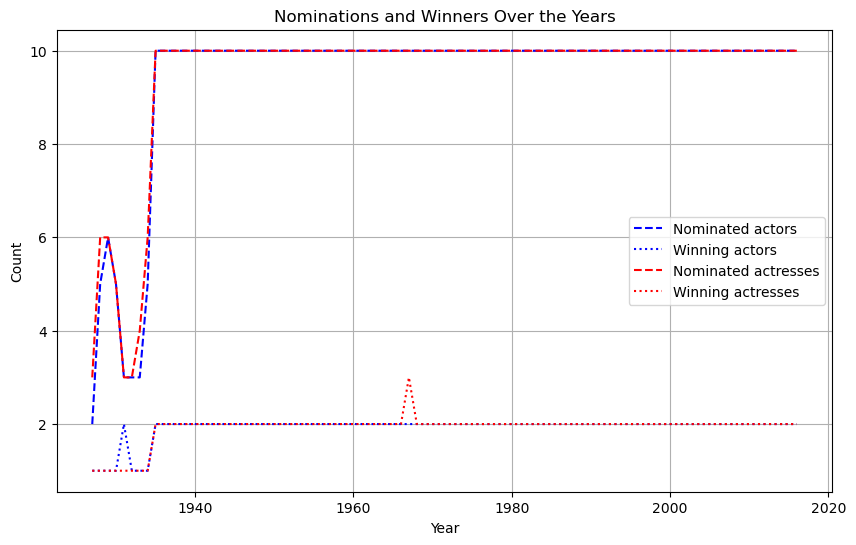

In [77]:
# Plot the lines
fig, ax = plt.subplots(figsize=(10, 6))

male_total_observations = pivot_table.loc['Male', ('Total Observations', slice(None))]
male_winners = pivot_table.loc['Male', ('Winners', slice(None))]
female_total_observations = pivot_table.loc['Female', ('Total Observations', slice(None))]
female_winners = pivot_table.loc['Female', ('Winners', slice(None))]
years = [n for n in range(1927,2017)]

plt.plot(years, male_total_observations, label='Nominated actors', color='blue', linestyle='--')
plt.plot(years, male_winners, label='Winning actors', color='blue', linestyle='dotted')
plt.plot(years, female_total_observations, label='Nominated actresses', color='red', linestyle='--')
plt.plot(years, female_winners, label='Winning actresses', color='red', linestyle='dotted')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Nominations and Winners Over the Years')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
characters_oscars = characters.merge(actors_oscars, left_on='Actor name', right_on='entity', how='left')

characters_oscars['entity'].isna().sum() # 418049
characters_oscars.shape[0] # 489192

print('There are {}% of Oscar nominees or winners in the movies dataset.'.format(round(100 - characters_oscars['entity'].isna().sum()/characters_oscars.shape[0] * 100,2)))
# How many nominees don't appear in the dataset?

There are 14.31% of Oscar nominees or winners in the movies dataset.


### Limitations of the dataset

The Oscars take place in the US and are usually political. We haven't found an exhaustive dataset of awards.
There is a Western bias as it is rare for actors popular in other parts of the world such as India to win an award outside the best international film category. Some film industries are very big outside of Hollywood, such as Bollywood and Nollywood.

No award ceremony is exempt from this national preference: The Academy Awards (The Oscars), The Australian Film Institute Awards, The BAFTA Film Awards (UK), the CESAR Film Awards (France), the Golden Bears (Berlin - Germany), the Golden Globes, the Golden Lions (Venice Film Festival), the Palme d'Or awards (Cannes), the Sundance Film Festival awards, etc.

We do not aim at doing an exhaustive analysis, but it is important here to understand that we have a Western bias and we might need to use other indicators to better understand success of outside actors.

In [79]:
# What are movie nationalities of actors that won an Oscar?

characters_oscars_movies = characters_oscars[characters_oscars['winner'] == True].merge(movies, on='Freebase movie ID', how='left') 

In [80]:
filtered_countries_counts = {country: count for country, count in countries_counts.items() if count > 500}
sorted_countries_counts = dict(sorted(filtered_countries_counts.items(), key=lambda item: item[1], reverse=True))

sorted_countries_counts
# A lot of countries are represented, but the US is still largely above the rest

{'United States of America': 34408,
 'India': 8411,
 'United Kingdom': 7868,
 'France': 4395,
 'Italy': 3163,
 'Japan': 2647,
 'Canada': 2534,
 'Germany': 2393,
 'Argentina': 1468,
 'Hong Kong': 1240,
 'Spain': 1136,
 'Australia': 1114,
 'South Korea': 887,
 'Mexico': 870,
 'Netherlands': 840,
 'Sweden': 657,
 'West Germany': 647,
 'China': 645,
 'Denmark': 610,
 'Soviet Union': 564}

### Initial analyses

**Predicting oscars with character metadata**

In [81]:
## Prepare the features vector for training ##

# Choose the relevant features
actors_features = ['Movie release date', 'Actor gender', 'Actor age at movie release', 'Actor height', 'Actor ethnicity']

X = characters_oscars[actors_features].copy()

# Removing missing values, for now imputations don't make sense here. 
# But because of ethnicity and height we get rid of a lot of observations
X_ = X[~(X.isna().any(axis=1))].copy()
len(X_[X_.isna().any(axis=1)])

X_['Actor age at movie release'] = X_['Actor age at movie release'].astype('category')

# Compute the number of days away from the first movie
X_.loc[:, 'release date'] = pd.to_datetime(X_['Movie release date'], format='mixed') # convert release date into date format 
X_['release date'] = (X_['release date'] - X_['release date'].min()).dt.days # and then into int

gender_mapping = {'F': 1, 'M': 2}
X_['Actor gender'] = X_['Actor gender'].map(gender_mapping) # Use a mapping to convert the 'gender' column to float

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to the categorical variable and transform it
X_['Encoded ethnicity'] = label_encoder.fit_transform(X_['Actor ethnicity'])

X_ = X_.drop('Movie release date', axis=1)
X_ = X_.drop('Actor ethnicity', axis=1)

In [82]:
display(X_)

,Actor gender,Actor age at movie release,Actor height,release date,Encoded ethnicity
1,1,27.0,1.780,33838,139
2,2,32.0,1.727,33838,351
5,1,52.0,1.727,33838,351
55,2,31.0,1.630,35429,135
56,2,34.0,1.870,35429,99
...,...,...,...,...,...
488400,2,21.0,1.790,15705,352
488404,1,30.0,1.746,32572,99
488416,1,21.0,1.720,33968,135
488417,2,55.0,1.740,33968,135


In [83]:
## Prepare the outcome vector for training ##

# We want integers as outcomes
outcome_mapping = {0: 'is nominated for an Oscar', 1: 'wins an Oscar', 2: 'gets nothing'}

characters_oscars.loc[characters_oscars['winner'].isna(), 'winner'] = 2 # missing values mean not winner nor nominated
y = characters_oscars['winner'].astype('int')

# We remove the same observations as for the features vector
y_ = y[~(X.isna().any(axis=1))]

In [84]:
display(y_)

1         2
2         2
5         2
55        2
56        2
         ..
488400    2
488404    2
488416    2
488417    2
488439    2
Name: winner, Length: 86640, dtype: int32

In [85]:
## Training ##

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Create and train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      5341
           1       0.34      0.22      0.26      1519
           2       0.98      0.99      0.99     10468

    accuracy                           0.88     17328
   macro avg       0.70      0.69      0.69     17328
weighted avg       0.87      0.88      0.87     17328



In [86]:
## Prediction of oscars based on an input vector of features ##

predicted_label = model.predict([[1,43,30000, 180, 120]])[0] # we need a mapping of ethnicities to interpret it
outcome = outcome_mapping[predicted_label]

print('This actor/actress {}.'.format(outcome))

This actor/actress gets nothing.


D:\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [87]:
## Which features are the most important? ##

feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances with feature names
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

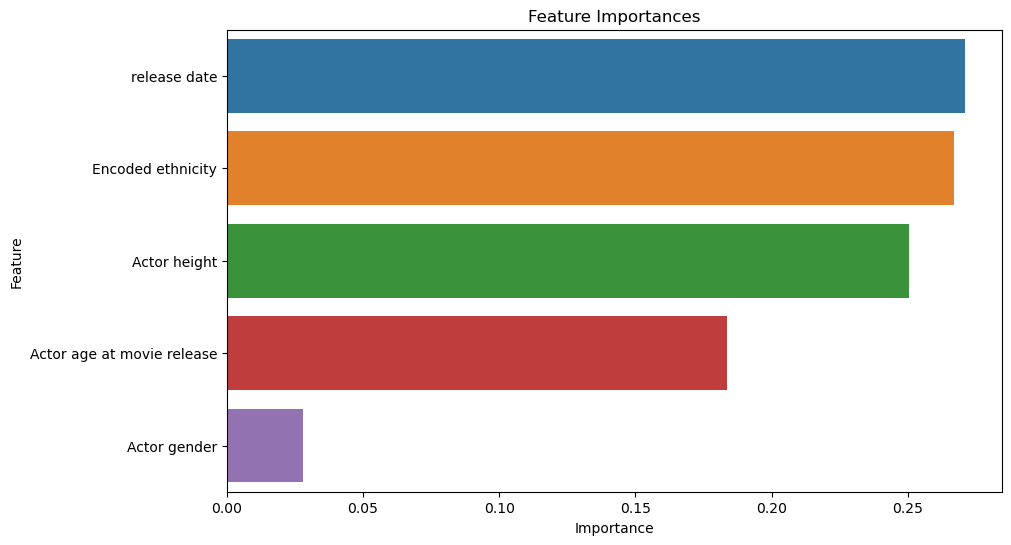

In [88]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

# It makes sense that gender does not matter much since both men and women win as much. 
# Maybe women are more likely to win as they are less represented. 
# Why does release date matter? as many oscars each year

# Next step is to show in which direction features matter and to include more features (eg. on movies)
# What is the value added of using ML here and not just a regression with interaction variables?

## 2.2 [IMDb movies' ratings](https://developer.imdb.com/non-commercial-datasets/)

We want to observe how successful an actor is through different scopes and the easiest way to judge an actor and a movie is with audience's ratings. Therefore we are using the IMDb datasets to analyze the performance of actors seen from the general public's perspective.

### Datasets manipulation

We will only be working with the following files :
- ratings.tsv which contains ratings for movies
- titles_imdb.tsv which contains the title of the movies

In [89]:
ratings = pd.read_csv('Data/ratings.tsv', sep='\t')
imdb_movies = pd.read_csv('Data/titles_imdb.tsv', sep='\t')

C:\Users\pasca\AppData\Local\Temp\ipykernel_13812\3750461216.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_movies = pd.read_csv('Data/titles_imdb.tsv', sep='\t')


In [90]:
display(ratings)

,tconst,averageRating,numVotes
0,tt0000001,5.7,2005
1,tt0000002,5.8,269
2,tt0000003,6.5,1908
3,tt0000004,5.5,178
4,tt0000005,6.2,2688
...,...,...,...
1366964,tt9916730,7.6,11
1366965,tt9916766,7.0,22
1366966,tt9916778,7.2,36
1366967,tt9916840,8.8,6


In [91]:
display(imdb_movies)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10298939,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10298940,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10298941,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10298942,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [92]:
movie_ratings = pd.merge(imdb_movies, ratings)
display(movie_ratings)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.7,2005
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",5.8,269
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1908
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",5.5,178
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2688
...,...,...,...,...,...,...,...,...,...,...,...
1366962,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama,7.6,11
1366963,tt9916766,tvEpisode,Episode #10.15,Episode #10.15,0,2019,\N,43,"Family,Game-Show,Reality-TV",7.0,22
1366964,tt9916778,tvEpisode,Escape,Escape,0,2019,\N,\N,"Crime,Drama,Mystery",7.2,36
1366965,tt9916840,tvEpisode,Horrid Henry's Comic Caper,Horrid Henry's Comic Caper,0,2014,\N,11,"Adventure,Animation,Comedy",8.8,6


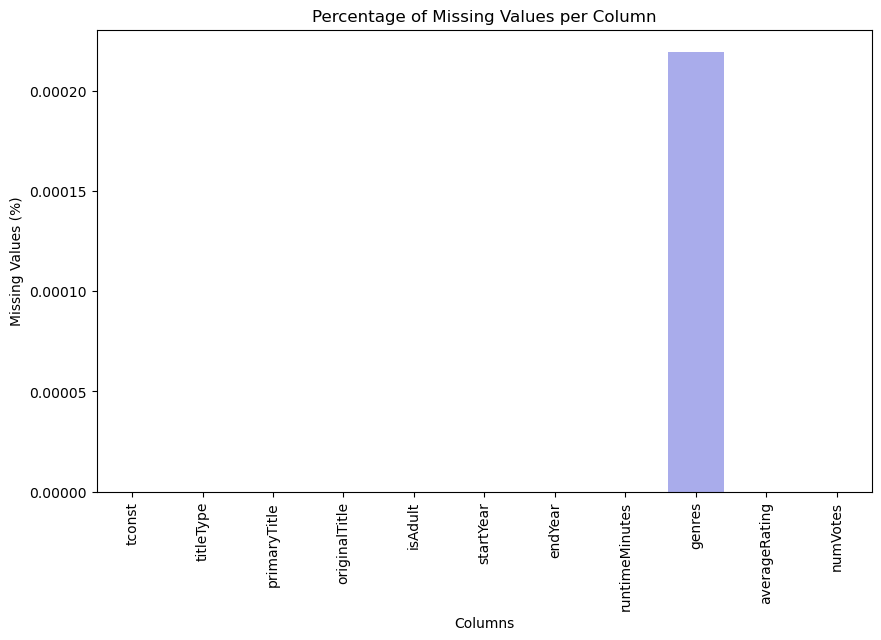

In [93]:
# Count missing values per column
missing_percent = (movie_ratings.isna().mean() * 100)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values)
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Missing Values (%)')
plt.title('Percentage of Missing Values per Column')
plt.show()

We now need to merge our new dataset with the movies dataset from the CMU Corpus.

In [94]:
movie_ratings_2 = pd.merge(movies, movie_ratings, left_on=["Movie name"], right_on=["primaryTitle"])
movie_ratings_2.head(10)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",tt0228333,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",4.9,56894
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",tt0594845,tvEpisode,Ghosts of Mars,Ghosts of Mars,0,2001,\N,\N,"Documentary,Short",7.6,20
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",tt0094806,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",5.6,40
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},tt0083949,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,5.9,623
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{'/m/06ppq': 'Silent film', '/m/02h40lc': 'Eng...",{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",tt0002894,short,The Gangsters,The Gangsters,0,1913,\N,35,"Comedy,Short",6.8,16
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{'/m/06ppq': 'Silent film', '/m/02h40lc': 'Eng...",{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",tt0139667,movie,The Gangsters,Les truands,0,1957,\N,105,"Comedy,Crime",5.6,33
6,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{'/m/06ppq': 'Silent film', '/m/02h40lc': 'Eng...",{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",tt27788655,movie,The Gangsters,The Gangsters,0,2019,\N,\N,Action,6.2,6
7,23070193,/m/064mmt5,The Gangsters,1956,NaN,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},{'/m/05p553': 'Comedy film'},tt0002894,short,The Gangsters,The Gangsters,0,1913,\N,35,"Comedy,Short",6.8,16
8,23070193,/m/064mmt5,The Gangsters,1956,NaN,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},{'/m/05p553': 'Comedy film'},tt0139667,movie,The Gangsters,Les truands,0,1957,\N,105,"Comedy,Crime",5.6,33
9,23070193,/m/064mmt5,The Gangsters,1956,NaN,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},{'/m/05p553': 'Comedy film'},tt27788655,movie,The Gangsters,The Gangsters,0,2019,\N,\N,Action,6.2,6


As displayed above, there are multiple movies that have the same name. So in order to avoid the confusion between movies' titles, we have to add another parameter to merge the two dataframes on: the most logical one would be the year.

In [95]:
movie_ratings["startYear"] = movie_ratings["startYear"].astype(str)

In [96]:
# Function to extract the year from the release date
def extract_year(date_string):
    try:
        date = pd.to_datetime(date_string)
        return date.year
    except (ValueError, TypeError):
        return date_string

In [97]:
movies['Year'] = movies['Movie release date'].apply(extract_year)
movies['Year'] = movies['Year'].astype(str)

In [98]:
display(movies)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",1988
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},1983
...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'},2011
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,{'/m/02h40lc': 'English Language'},"{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{'/m/03bxz7': 'Biographical film', '/m/07s9rl0...",2011
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}",1972
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ...",1992


In [99]:
movie_ratings_2 = pd.merge(movies, movie_ratings, left_on=["Movie name", "Year"], right_on=["primaryTitle", "startYear"])
display(movie_ratings_2)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Year,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",4.9,56894
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,tvEpisode,Ghosts of Mars,Ghosts of Mars,0,2001,\N,\N,"Documentary,Short",7.6,20
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",1988,...,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",5.6,40
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},1983,...,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,5.9,623
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{'/m/06ppq': 'Silent film', '/m/02h40lc': 'Eng...",{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",1913,...,short,The Gangsters,The Gangsters,0,1913,\N,35,"Comedy,Short",6.8,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51101,15394941,/m/03m6zh4,Gopi Kishan,1994-12-02,NaN,NaN,{'/m/03k50': 'Hindi Language'},{'/m/03rk0': 'India'},"{'/m/07s9rl0': 'Drama', '/m/02kdv5l': 'Action'...",1994,...,movie,Gopi Kishan,Gopi Kishan,0,1994,\N,161,"Action,Comedy,Drama",5.8,964
51102,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/0lsxr': 'Crime Fiction', '/m/01jfsb': 'Th...",1941,...,movie,The Ghost Train,The Ghost Train,0,1941,\N,85,"Comedy,Horror",6.2,1582
51103,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'},2011,...,tvMovie,Mermaids: The Body Found,Mermaids: The Body Found,0,2011,\N,82,Sci-Fi,4.6,1711
51104,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,{'/m/02h40lc': 'English Language'},"{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{'/m/03bxz7': 'Biographical film', '/m/07s9rl0...",2011,...,movie,Knuckle,Knuckle,0,2011,\N,97,"Biography,Documentary,Drama",6.8,3193


We notice that about 30,000 movies have been removed from the initial dataset.

Now let us merge with the actors dataframe and calculate the average rating for each actor.

In [100]:
actors_ratings = pd.merge(movie_ratings_2, characters, on="Wikipedia movie ID")
display(actors_ratings)

,Wikipedia movie ID,Freebase movie ID_x,Movie name,Movie release date_x,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Year,...,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",2001,...,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355412,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/0lsxr': 'Crime Fiction', '/m/01jfsb': 'Th...",1941,...,NaN,1900-01-14,M,NaN,NaN,Wilfrid Lawson,41.0,/m/0gcgrfv,NaN,/m/025w40r
355413,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/0lsxr': 'Crime Fiction', '/m/01jfsb': 'Th...",1941,...,NaN,1891-08-08,M,NaN,NaN,Morland Graham,NaN,/m/0gckksz,NaN,/m/0gc08qy
355414,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/0lsxr': 'Crime Fiction', '/m/01jfsb': 'Th...",1941,...,NaN,1869,M,NaN,NaN,D.J. Williams,NaN,/m/0gdk36r,NaN,/m/0gcwx9k
355415,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}",1972,...,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5


In [102]:
actors_ratings["avgRating"] = actors_ratings["averageRating"] * actors_ratings["numVotes"]

In [105]:
weighted_avg_rat = actors_ratings.groupby('Actor name')['avgRating'].sum() / actors_ratings.groupby('Actor name')['numVotes'].sum()
nb_movies_per_act = actors_ratings.groupby('Actor name')['Movie name'].count()

In [107]:
df_nb_movies = pd.DataFrame({'Actor': weighted_avg_rat.index, 'Movies count': nb_movies_per_act.values})
df_ratings = pd.DataFrame({'Actor': weighted_avg_rat.index, 'Rating': weighted_avg_rat.values})
df_result = pd.merge(df_ratings, df_nb_movies)
df_result_sort = df_result.sort_values(by="Rating", ascending=False)
display(df_result_sort)

,Actor,Rating,Movies count
93926,Taira Court,10.0,1
34469,Gloria Laso,10.0,1
49377,Josefina González,10.0,1
81800,Ricardo Fernández,10.0,1
88614,Sergio Moliner,9.9,1
...,...,...,...
85757,Ryan Christiansen,1.1,1
48766,Jon Jon Briones,1.1,1
36936,Hayley Chase,1.1,1
57241,Lawson Harris,1.0,1


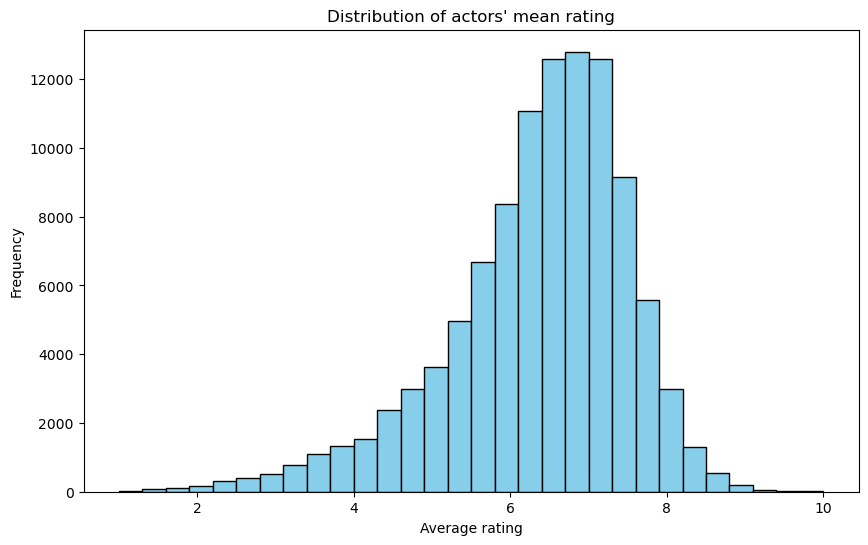

In [109]:
plt.figure(figsize=(10, 6))
plt.hist(df_result['Rating'], bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Average rating')
plt.ylabel('Frequency')
plt.title("Distribution of actors' mean rating")

plt.show()

In [110]:
df_result.describe()

,Rating,Movies count
count,104255.000000,104255.000000
mean,6.322880,3.400067
std,1.162767,7.310288
min,1.000000,1.000000
25%,5.704164,1.000000
50%,6.500000,1.000000
75%,7.100000,3.000000
max,10.000000,601.000000


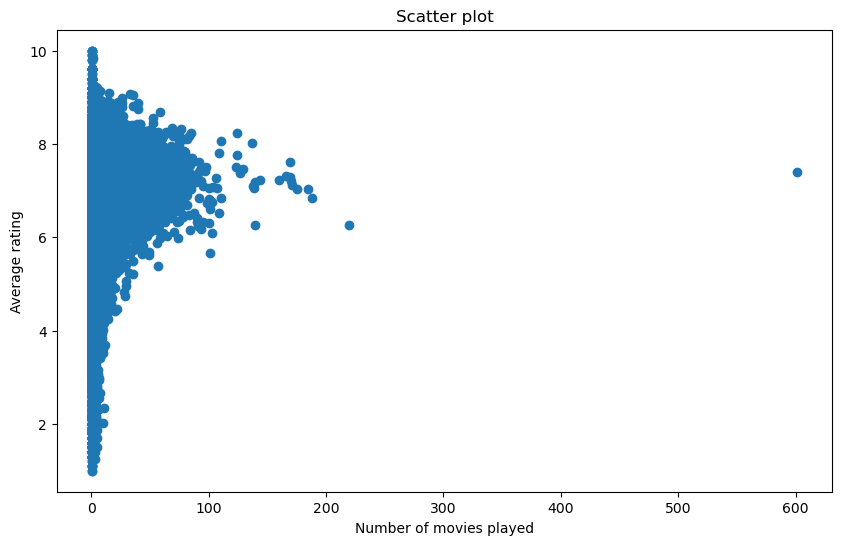

In [112]:
plt.figure(figsize=(10, 6))
plt.scatter(df_result['Movies count'], df_result['Rating'])
plt.xlabel('Number of movies played')
plt.ylabel('Average rating')
plt.title('Scatter plot')
plt.show()

In [118]:
# Removing the outlier for better visualization
df_visualize = df_result[df_result['Movies count'] < 600]

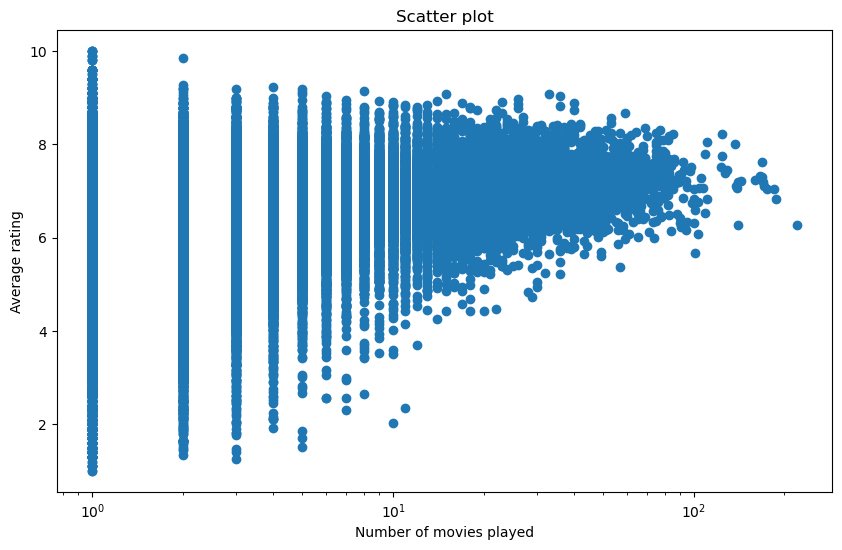

In [119]:
plt.figure(figsize=(10, 6))
plt.scatter(df_visualize['Movies count'], df_visualize['Rating'])
plt.xscale('log')
plt.xlabel('Number of movies played')
plt.ylabel('Average rating')
plt.title('Scatter plot')
plt.show()

Extreme values of ratings usually appear for actors who have played in very few movies. Actors who have played in more movies have their rating slightly skewed towards positive ratings. We will dive deeper into this analysis for the next and final milestone and also try to establish connections with the other factors.

## 3. Expected outcomes

We aim to provide a more nuanced understanding of the driving factors of success and allow our reader to interact with our results.

- Prediction of all types of success based on a feature input. This can be visualized for instance with a spider chart.
- Identification of important features for a given success indicator goal. This will highlight the power one has in being successful.
- Computation of success indicators for actors present in the dataset. This can be visualized with a research tool. 